In the following notebook reasons for attempts are made to find the features which incorporate racial bias into the data set. As noted from the Random forest feature importance graph the most imoortant features are:



1. Prior_counts
2. juv_misd_count
3. juv_other_count
4. age_cat
5. sex

Using these features I will try to predict race using these features to find if there are any features unknowingly incorporating racial component into the dataset.

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount = True)
#%cd /gdrive/My\ Drive

Mounted at /gdrive


In [ ]:
import pickle
import numpy as np
import pandas as pd
arr = []
file_name = 'data.pkl'
data = (pickle.load(open(r'/gdrive/My Drive/'+file_name,'rb')))

In [ ]:
#TODO: 1. Create inout dataset with the most important features
#      2. Create an output dataset and label all the categories 
#         except African-American as others.
 
inp_data = data[['age_cat', 'juv_misd_count', 'priors_count', 'sex', 'juv_other_count']].copy()
out_data = data[['race']].copy()
out_data.loc[out_data['race'] != 'African-American', 'race'] = 'Others'

All the categories except African-American are labeled as others due to the imbalanced distribution of the categories where almost 50% of the classes are African-American and rest 50% consist of other races(Caucassian, Native American, Hispanic etc.) 

In [ ]:
out_data['race'].value_counts()

African-American    5336
Others              5262
Name: race, dtype: int64

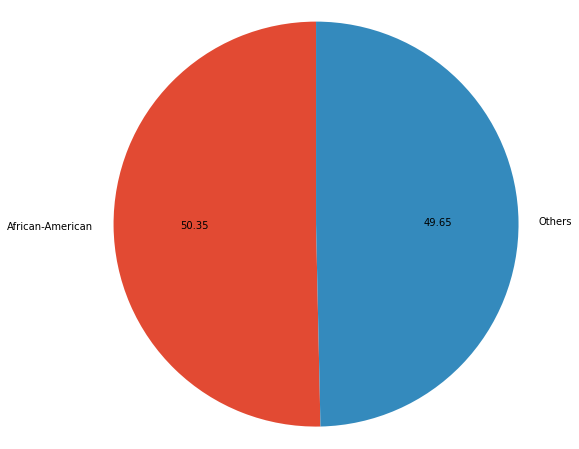

In [ ]:
import matplotlib.pyplot as plt
#dict 'race' is sreated for distribution of race feature
race = out_data['race'].value_counts().to_dict()
#label: type of race
label = []
#count: number of people of that race
count = []

for i in race.items():
  #values are stored in count, label using race dict 
  label.append(i[0])
  count.append(i[1])

plt.style.use(['ggplot'])
plt.figure(figsize=(8,8))
plt.pie(count, labels = label, autopct='%1.2f', startangle=90)
plt.axis('equal')
plt.show()

In order to balance the classes in the output data classes other than African-American are renamed as "Others" this will help us to judge the performance of models on the basis of accuracy itself.

In [ ]:
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_validate
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve

In [ ]:
def get_dummies(df):
  #Binarizes the features of dataset passed in df
  df = pd.get_dummies(df)
  return df

In [ ]:
def drop_col(df, col_name):
  #Drops column from dataset passed in col_name 
  df.drop(col_name, axis = 1)
  return df

In [ ]:
def data_split(inp_data, out_data):
  X_train, X_test, y_train, y_test = train_test_split(inp_data.to_numpy(), out_data.to_numpy(), test_size=0.20, random_state=42, stratify = out_data.to_numpy())
  return X_train, X_test, y_train, y_test

In [ ]:
svm_parameters ={
              "kernel": ["rbf"],
              "C": [0.1, 0.5, 1, 5],
              "gamma": [0.01, 0.05, 0.1]
            }

In [ ]:
def svm_classifier(X_train, X_test, y_train, y_test, parameters):
  '''The following function when called will perform an exhaustive search 
      over all the para,eters to find the set of parameters which give 
      the best fit of parameters with lowest cross validation error and 
      uses svm classifier to fit the parameters into the dataset'''
      
  svm = SVC(probability = True)

  print("finding best value for C and gamma")
  print("################")

  #Finding best parameters C and gamma using GridserchCV

  clf = GridSearchCV(svm, param_grid = parameters,  cv=5, n_jobs=-1, verbose=0.3, refit = 'precision_weighted')
  clf.fit(X_train, y_train.ravel())
  ypred = clf.predict(X_test)

  tuned_clf = clf.best_estimator_
  acc = clf.score(X_test,y_test.ravel())
  
  print("#################")
  print()
  print("Classifier accuracy is",acc)
  
  return tuned_clf, acc

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 5)]
max_features = ['sqrt']
max_depth = [int(x) for x in np.linspace(10, 40, num = 5)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True]

rfc_parameters = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
def rfc_clf(X_train, X_test, y_train, y_test, parameters):
  '''The following function when called will perform an exhaustive search 
    over all the para,eters to find the set of parameters which give 
     the best fit of parameters with lowest cross validation error and 
     uses rfc classifier to fit the parameters into the dataset'''

  rfc = RandomForestClassifier()
  clf = GridSearchCV(rfc, param_grid = parameters,  cv=3, n_jobs=-1, verbose=0.3, refit = 'precision_weighted')
  clf.fit(X_train, y_train.ravel())
  ypred = clf.predict(X_test)
  y_predprob = clf.predict_proba(X_test)

  tuned_clf = clf.best_estimator_
  acc = clf.score(X_test,y_test.ravel())
  print("####################")
  print()
  print("Classifier accuracy is",acc)

  return tuned_clf, acc

In [ ]:
mlp_parameters = {
      'hidden_layer_sizes': [(20,)],
      'activation': ['logistic', 'relu'],
      'solver': ['adam', 'lbfgs', 'sgd'],
      'alpha': [int(x) for x in np.linspace(10, 110, num = 5)],
      'learning_rate': ['constant','adaptive'],
}

In [ ]:
def mlp_clf(X_train, X_test, y_train, y_test, parameters):
  '''The following function when called will perform an exhaustive search 
    over all the para,eters to find the set of parameters which give 
    the best fit of parameters with lowest cross validation error and 
    uses mlp classifier to fit the parameters into the dataset'''

  mlp = MLPClassifier(max_iter = 2000)
  clf = GridSearchCV(mlp, param_grid = parameters,  cv=3, n_jobs=-1, verbose=0.3, refit = 'precision_weighted')
  clf.fit(X_train, y_train.ravel())
  ypred = clf.predict(X_test)

  tuned_clf = clf.best_estimator_
  acc = clf.score(X_test,y_test.ravel())
  print("#####################")
  print()
  print("Classifier accuracy is",acc)
  return tuned_clf, acc

## **Support Vector Machine**

In [ ]:
#TODO: 1. Fit the model in the dataset without any features removed
#      2. Iterate over list "drop_col_name" and remove that feature
#      3. Fit the model in each successive dataset created
#      4. Store the results and datset types in datset_type and svm_res

#stores the type of dataset used
dataset_type = []

#stores the accuracy of the model
svm_res = []         

#specifies the feature to be dropped from the dataset
drop_col_name = ['sex', 'juv_other_count', 'juv_misd_count', 'age_cat']
df = inp_data
X_train, X_test, y_train, y_test = data_split(get_dummies(df), out_data)

print("******************Using Base Dataset*********************")
print()
dataset_type.append('base_dataset')

tuned_clf_svm, svm_acc = svm_classifier(X_train, X_test, y_train, y_test, svm_parameters)
svm_res.append(svm_acc) 

#A column is dropped at each iteration
for i in drop_col_name:
  df = drop_col(df, i)
  X_train, X_test, y_train, y_test = data_split(get_dummies(df), out_data)

  print("********************On removing",i+"********************")
  print()
  dataset_type.append(i+'_removed')
  #Train and test dataset are passed as parameters to svm classifier which returns accuracy
  tuned_clf_svm, svm_acc = svm_classifier(X_train, X_test, y_train, y_test, svm_parameters)
  svm_res.append(svm_acc)

******************Using Base Dataset*********************

finding best value for C and gamma
################
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  9.0min finished


#################

Classifier accuracy is 0.6216981132075472
********************On removing sex********************

finding best value for C and gamma
################
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  9.0min finished


#################

Classifier accuracy is 0.6216981132075472
********************On removing juv_other_count********************

finding best value for C and gamma
################
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  9.0min finished


#################

Classifier accuracy is 0.6216981132075472
********************On removing juv_misd_count********************

finding best value for C and gamma
################
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  9.0min finished


#################

Classifier accuracy is 0.6216981132075472
********************On removing age_cat********************

finding best value for C and gamma
################
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  9.0min finished


#################

Classifier accuracy is 0.6216981132075472


## **Random Forest Classifier**

In [ ]:
#Similar procedure to the above cell is followed here
 
rfc_res = []       
drop_col_name = ['sex', 'juv_other_count', 'juv_misd_count', 'age_cat']
df = inp_data
X_train, X_test, y_train, y_test = data_split(get_dummies(df), out_data)

print("******************Using Base Dataset*********************")
print()
dataset_type.append('base_dataset')
 

tuned_clf_rfc, rfc_acc = rfc_clf(X_train, X_test, y_train, y_test, rfc_parameters)
rfc_res.append(rfc_acc)


for i in drop_col_name:
  df = drop_col(df, i)
  X_train, X_test, y_train, y_test = data_split(get_dummies(df), out_data)

  print("********************On removing",i+"********************")
  print()
  tuned_clf_rfc, rfc_acc = rfc_clf(X_train, X_test, y_train, y_test, rfc_parameters)
  rfc_res.append(rfc_acc)

******************Using Base Dataset*********************

Fitting 3 folds for each of 270 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   36.0s
[Parallel(n_jobs=-1)]: Done 225 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 512 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:  9.3min finished


####################

Classifier accuracy is 0.6117924528301887
********************On removing sex********************

Fitting 3 folds for each of 270 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done 225 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 512 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:  9.3min finished


####################

Classifier accuracy is 0.6127358490566037
********************On removing juv_other_count********************

Fitting 3 folds for each of 270 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done 225 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 512 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:  9.3min finished


####################

Classifier accuracy is 0.6146226415094339
********************On removing juv_misd_count********************

Fitting 3 folds for each of 270 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done 225 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 512 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:  9.3min finished


####################

Classifier accuracy is 0.6160377358490566
********************On removing age_cat********************

Fitting 3 folds for each of 270 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done 225 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 512 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:  9.3min finished


####################

Classifier accuracy is 0.6117924528301887


## **Multiple Layer Perceptron**

In [ ]:
#Similar procedure to the above cell is followed here

mlp_res = []          
drop_col_name = ['sex', 'juv_other_count', 'juv_misd_count', 'age_cat']
df = inp_data
X_train, X_test, y_train, y_test = data_split(get_dummies(df), out_data)

print("******************Using Base Dataset*********************")
print()
dataset_type.append('base_dataset')

tuned_clf_mlp, mlp_acc = mlp_clf(X_train, X_test, y_train, y_test, mlp_parameters)
mlp_res.append(mlp_acc)

for i in drop_col_name:
  df = drop_col(df, i)
  X_train, X_test, y_train, y_test = data_split(get_dummies(df), out_data)

  print("********************On removing",i+"********************")
  print()

  tuned_clf_mlp, mlp_acc = mlp_clf(X_train, X_test, y_train, y_test, mlp_parameters)
  mlp_res.append(mlp_acc)

******************Using Base Dataset*********************

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.8min finished


#####################

Classifier accuracy is 0.6221698113207547
********************On removing sex********************

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.8min finished


#####################

Classifier accuracy is 0.6202830188679245
********************On removing juv_other_count********************

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.9min finished


#####################

Classifier accuracy is 0.6221698113207547
********************On removing juv_misd_count********************

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.8min finished


#####################

Classifier accuracy is 0.6165094339622641
********************On removing age_cat********************

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.8min finished


#####################

Classifier accuracy is 0.6221698113207547


([0, 1, 2, 3, 4], <a list of 5 Text major ticklabel objects>)

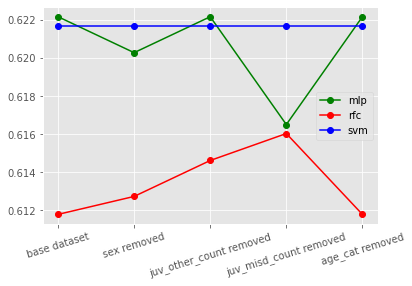

In [ ]:
dataset_type = ['base dataset', 'sex removed', 'juv_other_count removed', 'juv_misd_count removed', 'age_cat removed']
plt.style.use(['ggplot'])
plt.tight_layout()
plt.plot(dataset_type, mlp_res, 'o-', label = 'mlp', color = 'g')
plt.plot(dataset_type, rfc_res, 'o-', label = 'rfc', color = 'r')
plt.plot(dataset_type, svm_res, 'o-', label = 'svm', color = 'b')
plt.legend(loc="best")
plt.xticks(rotation=17)

Using accuracy to judge the performance of models will be reasonable as the classes in the dataset are balanced 

The above graph shows that MLP predicts race with the highest accuracy using only the prior counts (i.e when all the other features are removed iteratively).

Whereas Random forest gives the highest accuracy when the dataset contained both priors count and age_cat

In [ ]:
df = data
#Dataset is divided according to the race into two parts
df_afr = df[df.race=='African-American']
df_other = df[df.race!='African-American']

In [ ]:
#All the races other than African-American are termed as "Other"
df_other['race'] = 'Other'

<BarContainer object of 34 artists>

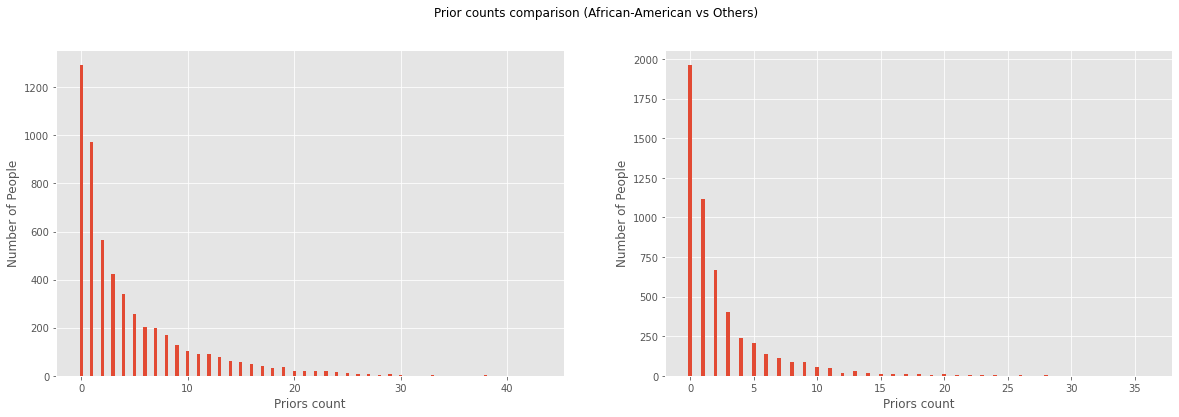

In [ ]:
import matplotlib.pyplot as plt
fig, (axs1,axs2) = plt.subplots(1,2, figsize = (20,6))
fig.suptitle('Prior counts comparison (African-American vs Others)')

#A list for prior counts and number of people is formed.
count = df_afr['priors_count'].value_counts()
prior_count_afr = count.index.tolist()
population_afr = count.values.tolist()

count = df_other['priors_count'].value_counts()
prior_count_cau = count.index.tolist()
population_cau = count.values.tolist()

#barplots for both the dataset is created
axs1.set_xlabel('Priors count')
axs1.set_ylabel('Number of People')
axs1.bar(prior_count_afr, population_afr, width=0.3)
axs2.set_xlabel('Priors count')
axs2.set_ylabel('Number of People')
axs2.bar(prior_count_cau, population_cau, width=0.3)

From the above graph it can be inferred that the overall priors count of African-American community is more than the rest of the races because 

1. In the case of other races(i.e the second graph) the number of people decreases rapidly as the priors count goes beyond 5 

2. Whereas in case of Afican-American race the number of people decreases less rapidly as compared to the other races 

3. Also the number of priors count go as far as 43 whereas in case of other races overall priors count does not go beyond 35 


# Conclusion

From the above results it is depicted that the most effective feature to predict race is priors_count using which the models can alone predict race with a hugh accuracy. Due to which we can say that their is a racial feature incorporated into the dataset unknowingly.



---



The following results might seem to be reasonable under the following assumption as follows:


Our dataset mostly contains offenses like Battery, arrest case no charge, Possession of drugs, etc and very few cases of very high charge crimes therefore, for such not so severe charges COMPAS algorithm doesnot provide decile scores based only on the current chrarge but rather consider their history too in which priors count play a major role which further results in providing higher scores to African-Americans(they have higher overall priors count) even though their chrges are not as high as Native Americans or any other race.
